In [142]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
from dataAnalyzer import *
from private_tool import *
from dataHandler import *
from numpy import array
import pandas as pd


In [143]:
experimentNum = 9
experimentIdx = 4
Experiments = [MotorImageryDataset(parentDirectory(dir=currDir, separator="\\", n=1)+'/bcicompetitionIV2a/A0'+str(i+1)+'T.npz') for i in range(experimentNum)]

In [144]:
channels = [7, 9, 10, 11]
samplingRate = 250 #Hz
trialsByClasses = array([i.get_trials_by_classes(channels=channels) for i in Experiments])

In [145]:
len(trialsByClasses[0]["left"][0])

69

In [146]:
channelNum = len(channels)
m = len(trialsByClasses[0]["left"])
channelNum, m

(4, 4)

In [147]:
bandpassedTrialsByClasses = [{i:[[] for _ in range(channelNum)] for i in j.mi_types.values()} for j in Experiments]
for k in range(experimentNum):
    for key in trialsByClasses[k].keys():
        for i in range(channelNum):
            bandpassedTrialsByClasses[k][key][i] = np.array([bandpass_filter(data=trialsByClasses[k][key][i][j], 
                                                                sample_rate=samplingRate, 
                                                                cutoff_low=5, 
                                                                cutoff_high=50)\
                                                for j in range(len(trialsByClasses[k][key][i]))])

In [148]:
# bandpassedTrialsByClasses[2]["left"][2].shape

In [149]:
# 현재 상태는 experiment - class - channel - trial - signal
# class - experiment - trial - channel - signal로 수정하자
bandpassedTrialsByClasses = {key:array([[bandpassedTrialsByClasses[i][key][j] for j in range(channelNum)] for i in range(experimentNum)]) for key in Experiments[0].mi_types.values()}
# bandpassedTrialsByClasses["left"][8][0].shape
# i: experiment
# j: trial

C:\Users\jihun\AppData\Local\Temp\ipykernel_2724\3323506164.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bandpassedTrialsByClasses = {key:array([[bandpassedTrialsByClasses[i][key][j] for j in range(channelNum)] for i in range(experimentNum)]) for key in Experiments[0].mi_types.values()}


In [150]:
minTrialsNum = sorted([len(bandpassedTrialsByClasses["left"][i][0]) for i in range(experimentNum)])[0]
bandpassedTrialsByClasses = {i:[bandpassedTrialsByClasses[i][j] for j in range(experimentNum)] for i in Experiments[0].mi_types.values()}

In [151]:
left_csp_filter = CSP_filter(len(bandpassedTrialsByClasses["left"][experimentIdx]), bandpassedTrialsByClasses["left"][experimentIdx])
right_csp_filter = CSP_filter(len(bandpassedTrialsByClasses["right"][experimentIdx]), bandpassedTrialsByClasses["right"][experimentIdx])
tongue_csp_filter = CSP_filter(len(bandpassedTrialsByClasses["tongue"][experimentIdx]), bandpassedTrialsByClasses["tongue"][experimentIdx])
foot_csp_filter = CSP_filter(len(bandpassedTrialsByClasses["foot"][experimentIdx]), bandpassedTrialsByClasses["foot"][experimentIdx])

In [152]:
bandpassedTrials = {i:[] for i in Experiments[0].mi_types.values()}
for i in Experiments[0].mi_types.values():
    for j in range(len(bandpassedTrialsByClasses)):
        bandpassedTrials[i]

In [153]:
# CSP_passed_left_data = np.array([[bandpassedTrialsByClasses[i][j].T@left_csp_filter for j in range(minTrialsNum)] for i in range(experimentNum)])
CSP_passed_left_data = [j.T@left_csp_filter for j in bandpassedTrialsByClasses["left"][experimentIdx]]
CSP_passed_right_data = [j.T@right_csp_filter for j in bandpassedTrialsByClasses["right"][experimentIdx]]
CSP_passed_tongue_data = [j.T@tongue_csp_filter for j in bandpassedTrialsByClasses["tongue"][experimentIdx]]
CSP_passed_foot_data = [j.T@foot_csp_filter for j in bandpassedTrialsByClasses["foot"][experimentIdx]]

In [154]:
len(CSP_passed_left_data)

4

In [155]:
# bandpassedTrialsByClasses["right"][0]["right"][0]

In [156]:
print(array(CSP_passed_left_data).shape)
CSP_passed_left_data = [np.array([j.T for j in i]).T for i in CSP_passed_left_data]
CSP_passed_right_data = [np.array([j.T for j in i]).T for i in CSP_passed_right_data]
CSP_passed_tongue_data = [np.array([j.T for j in i]).T for i in CSP_passed_tongue_data]
CSP_passed_foot_data = [np.array([j.T for j in i]).T for i in CSP_passed_foot_data]

(4, 1875, 63)


In [157]:
array(CSP_passed_left_data).shape

(4, 63, 1875)

In [158]:
CSP_passed_left_data = array([i.T for i in array(CSP_passed_left_data).T]).T
CSP_passed_right_data = array([i.T for i in array(CSP_passed_right_data).T]).T
CSP_passed_tongue_data = array([i.T for i in array(CSP_passed_tongue_data).T]).T
CSP_passed_foot_data = array([i.T for i in array(CSP_passed_foot_data).T]).T

In [159]:
from math import log
m = 2
print(len(CSP_passed_left_data))

leftVar = np.array([np.array([np.var(CSP_passed_left_data[i][j]) for j in range(channelNum)]) for i in range(minTrialsNum)])
rightVar = np.array([np.array([np.var(CSP_passed_right_data[i][j]) for j in range(channelNum)]) for i in range(minTrialsNum)])
tongueVar = np.array([np.array([np.var(CSP_passed_tongue_data[i][j]) for j in range(channelNum)]) for i in range(minTrialsNum)])
footVar = np.array([np.array([np.var(CSP_passed_foot_data[i][j]) for j in range(channelNum)]) for i in range(minTrialsNum)])


leftVarRatio = np.array([np.array([log(leftVar[i][j-m]/sum(leftVar[i])) for j in range(m*2)]) for i in range(minTrialsNum)])
rightVarRatio = np.array([np.array([log(rightVar[i][j-m]/sum(rightVar[i])) for j in range(m*2)]) for i in range(minTrialsNum)])
tongueVarRatio = np.array([np.array([log(tongueVar[i][j-m]/sum(tongueVar[i])) for j in range(m*2)]) for i in range(minTrialsNum)])
footVarRatio = np.array([np.array([log(footVar[i][j-m]/sum(footVar[i])) for j in range(m*2)]) for i in range(minTrialsNum)])

63


In [160]:
leftVarRatioDF = pd.DataFrame(leftVarRatio)
rightVarRatioDF = pd.DataFrame(rightVarRatio)
tongueVarRatioDF = pd.DataFrame(tongueVarRatio)
footVarRatioDF = pd.DataFrame(footVarRatio)

labelDF = pd.DataFrame([0]*minTrialsNum + [1]*minTrialsNum + [2]*minTrialsNum + [3]*minTrialsNum)

In [161]:
VarRatioDF = pd.concat([leftVarRatioDF, rightVarRatioDF, tongueVarRatioDF, footVarRatioDF], axis=0)
VarRatioDF = VarRatioDF.reset_index()
VarRatioDF = pd.concat([VarRatioDF, labelDF], axis=1).iloc[:,1:]
VarRatioDF.columns = [f"{n}" for n in range(m*2)] + ["target"]
VarRatioDF

,0,1,2,3,target
0,-1.341686,-1.375909,-1.508145,-1.329289,0
1,-1.319647,-1.360280,-1.540549,-1.339723,0
2,-1.322623,-1.360038,-1.560490,-1.320955,0
3,-1.383672,-1.407935,-1.430328,-1.326271,0
4,-1.335653,-1.396957,-1.542515,-1.287998,0
...,...,...,...,...,...
207,-1.338300,-1.396813,-1.525992,-1.298579,3
208,-1.375813,-1.437291,-1.413934,-1.321966,3
209,-1.344126,-1.358995,-1.538981,-1.317836,3
210,-1.330549,-1.475510,-1.480067,-1.275171,3


In [162]:

x = VarRatioDF.drop(['target'], axis=1).values 
y = VarRatioDF['target'].values # 종속변인 추출
x = StandardScaler().fit_transform(x)
pd.DataFrame(x)

,0,1,2,3
0,0.312046,0.719970,-0.279203,-0.743181
1,1.409489,1.142882,-0.931133,-1.192978
2,1.261292,1.149447,-1.332310,-0.383886
3,-1.778769,-0.146660,1.286371,-0.613077
4,0.612432,0.150402,-0.970672,1.036928
...,...,...,...,...
207,0.480619,0.154308,-0.638249,0.580757
208,-1.387416,-0.941042,1.616212,-0.427467
209,0.190530,1.177671,-0.899586,-0.249439
210,0.866641,-1.975266,0.285701,1.589894


In [163]:
n_componunts = 3
PCA = PrincipalComponentAnalysis(n_componunts=n_componunts, data=x)
principalDf = PCA.principalDf

In [164]:
sum(PCA.explained_variance_ratio_())

0.9997188050165551

In [165]:
pd.concat([principalDf, labelDF], axis=1)

,principal component1,principal component2,principal component3,0
0,-0.705338,-0.839368,-0.208438,0
1,-1.968275,-1.010844,-0.828835,0
2,-2.157219,-0.376843,-0.196458,0
3,1.949052,-1.086559,0.486541,0
4,-1.073998,1.030546,0.446548,0
...,...,...,...,...
207,-0.776947,0.591928,0.211527,3
208,2.322933,-0.440422,-0.121450,3
209,-1.269473,-0.658232,0.499805,3
210,0.629538,2.521865,-0.711064,3


In [166]:
# import matplotlib.pyplot as plt

# fig = plt.figure(figsize = (8, 8))
# ax = fig.add_subplot(1, 1, 1)
# ax.set_xlabel('Principal Component 1', fontsize = 15)
# ax.set_ylabel('Principal Component 2', fontsize = 15)
# ax.set_title('1 component PCA', fontsize=20)

# targets = [0, 1, 2, 3]
# colors = ['r', 'g', 'b', 'purple']
# for target, color in zip(targets,colors):
#     indicesToKeep = VarRatioDF['target'] == target
#     ax.scatter(principalDf.loc[indicesToKeep, 'principal component1']
#                , principalDf.loc[indicesToKeep, 'principal component2']
#                , c = color
#                , s = 50, alpha=0.5)
# ax.legend(targets)
# ax.grid()

In [167]:
# last_data = pd.concat([principalDf.loc[:, 'principal component1'], 
#     principalDf.loc[:, 'principal component2'], 
#     labelDF], axis=1)

# last_data.columns = ['principal component1', 'principal component2', 'label']           

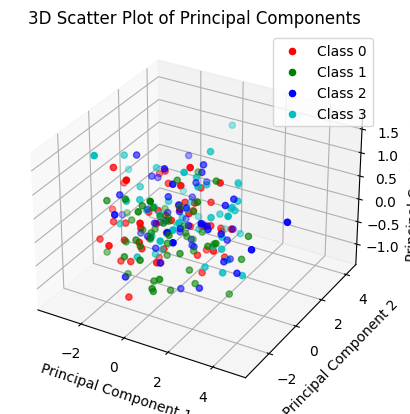

In [168]:


# 데이터를 DataFrame으로 생성
df = pd.concat([principalDf, labelDF], axis=1)
df.columns = [f"principal component{i+1}" for i in range(n_componunts)]+["label"]

# 3D scatter plot 그리기
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 클래스별로 색상을 다르게 설정
colors = ['r', 'g', 'b', 'c']
for i in range(4):  # 클래스 개수에 맞게 범위 설정
    subset = df[df['label'] == i]
    ax.scatter(subset['principal component1'], subset['principal component2'], subset['principal component3'], c=colors[i], label=f'Class {i}')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D Scatter Plot of Principal Components')
ax.legend()
plt.show()